In [ ]:
import torch
import tensorflow as tf
import random
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile
local_zip="/content/drive/MyDrive/PlantVillage.zip"


In [ ]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()


In [ ]:
train_size=0.9

In [ ]:
import os
files=os.listdir('PlantVillage')

In [ ]:
files

['Pepper__bell___healthy',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Potato___healthy',
 'Potato___Early_blight',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Potato___Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Bacterial_spot',
 'Tomato_Late_blight',
 'Tomato_Septoria_leaf_spot']

In [ ]:
train_dir='PlantVillage/training'
test_dir='PlantVillage/testing'

In [ ]:
test_dir

'PlantVillage/testing'

In [ ]:
os.makedirs(train_dir)
os.makedirs(test_dir)

In [ ]:
def split_data(source_dir,training_dir,testing_dir,split_size):
  files=os.listdir(source_dir)
  random.shuffle(files)
  split_index=int(len(files)*split_size)
  training_files=files[:split_index]
  testing_files=files[split_index:]

  for file in training_files:
    source=os.path.join(source_dir,file)
    destination=os.path.join(training_dir,file)
    if os.path.getsize(source)>0:
      copyfile(source,destination)
    else:
      print(f"{file} is zero length,so ignoring")

  for file in testing_files:
    source=os.path.join(source_dir,file)
    destination=os.path.join(testing_dir,file)
    if os.path.getsize(source)>0:
      copyfile(source,destination)
    else:
      print(f"{file} is zero length,so ignoring")
  pass

In [ ]:
os.makedirs('PlantVillage/training/early_blight')
os.makedirs('PlantVillage/training/late_blight')
os.makedirs('PlantVillage/training/healthy')

In [ ]:
os.makedirs('PlantVillage/testing/early_blight')
os.makedirs('PlantVillage/testing/late_blight')
os.makedirs('PlantVillage/testing/healthy')

In [ ]:
source_dirs=['PlantVillage/Potato___Early_blight','PlantVillage/Potato___Late_blight','PlantVillage/Potato___healthy']

In [ ]:
training_dir_early_blight='PlantVillage/training/early_blight'
training_dir_late_blight='PlantVillage/training/late_blight'
training_dir_healthy='PlantVillage/training/healthy'
testing_dir_early_blight='PlantVillage/testing/early_blight'
testing_dir_late_blight='PlantVillage/testing/late_blight'
testing_dir_healthy='PlantVillage/testing/healthy'



split_data(source_dirs[0],training_dir_early_blight,testing_dir_early_blight,train_size)
split_data(source_dirs[1],training_dir_late_blight,testing_dir_late_blight,train_size)
split_data(source_dirs[2],training_dir_healthy,testing_dir_healthy,train_size)

In [ ]:
def train_test_generators(training_dir,testing_dir):
  train_datagen=ImageDataGenerator(
      rescale=1/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

  train_generator=train_datagen.flow_from_directory(
      directory=training_dir,
      batch_size=32,
      class_mode='categorical',
      target_size=(256,256)
  )

  test_datagen=ImageDataGenerator(
      rescale=1/255)

  test_generator=test_datagen.flow_from_directory(
      directory=testing_dir,
      batch_size=32,
      class_mode='categorical',
      target_size=(256,256)
  )

  return train_generator,test_generator

In [ ]:
TRAINING_DIR='PlantVillage/training'
TESTING_DIR='PlantVillage/testing'
train_generator,test_generator=train_test_generators(TRAINING_DIR,TESTING_DIR)

Found 2129 images belonging to 3 classes.
Found 409 images belonging to 3 classes.


In [ ]:
train_generator

In [ ]:
def create_model():
  model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(256,256,3)),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512,activation='relu'),
      tf.keras.layers.Dense(3,activation='softmax')

  ])

  model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [ ]:
model=create_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.999):
      print('\n Reached 99.9% accuracy so cancelling training')
      self.model.stop_training=True

In [ ]:
callbacks=myCallback()
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    verbose=2
)

Epoch 1/100
67/67 - 43s - loss: 0.9408 - accuracy: 0.5101 - val_loss: 0.8345 - val_accuracy: 0.6919 - 43s/epoch - 643ms/step
Epoch 2/100
67/67 - 37s - loss: 0.7890 - accuracy: 0.6923 - val_loss: 0.6458 - val_accuracy: 0.6455 - 37s/epoch - 553ms/step
Epoch 3/100
67/67 - 35s - loss: 0.5739 - accuracy: 0.7496 - val_loss: 0.5957 - val_accuracy: 0.7262 - 35s/epoch - 520ms/step
Epoch 4/100
67/67 - 37s - loss: 0.4891 - accuracy: 0.7816 - val_loss: 0.3506 - val_accuracy: 0.8484 - 37s/epoch - 545ms/step
Epoch 5/100
67/67 - 36s - loss: 0.3645 - accuracy: 0.8502 - val_loss: 0.4847 - val_accuracy: 0.7653 - 36s/epoch - 535ms/step
Epoch 6/100
67/67 - 36s - loss: 0.3387 - accuracy: 0.8614 - val_loss: 0.2939 - val_accuracy: 0.8802 - 36s/epoch - 533ms/step
Epoch 7/100
67/67 - 35s - loss: 0.3512 - accuracy: 0.8675 - val_loss: 0.1720 - val_accuracy: 0.9315 - 35s/epoch - 528ms/step
Epoch 8/100
67/67 - 36s - loss: 0.3107 - accuracy: 0.8830 - val_loss: 0.4391 - val_accuracy: 0.7971 - 36s/epoch - 541ms/step


In [ ]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
loss=history.history['val_loss']

In [ ]:
epochs=range(len(acc))


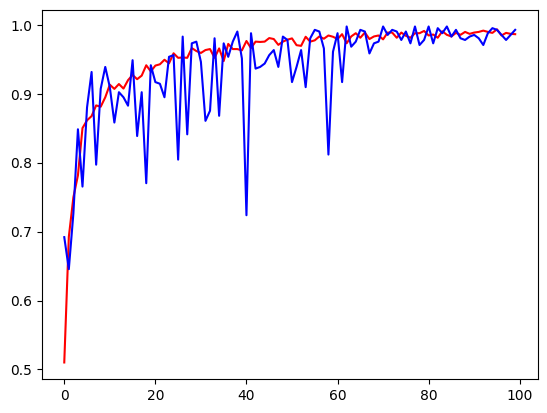

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs,acc,'r',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Valiadtion accuracy')
plt.figure()
plt.show()

In [ ]:
from tensorflow.keras.models import save_model

save_model(model, 'model.h5')

<ipython-input-28-86b39f432807>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'model.h5')


In [ ]:
import requests

url = 'https://example.com/path/to/model.pkl'
filename = 'model.pkl'

response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

print("Model downloaded successfully.")

Model downloaded successfully.


In [ ]:
import pick